In [485]:
import astropy.units as u
import astropy.coordinates as coord
import matplotlib.pyplot as plt
import numpy as np
import gala.integrate as gi
import gala.dynamics as gd
import gala.potential as gp
from gala.units import galactic

First, define a gravitational potential.

In [486]:
pot = gp.MilkyWayPotential()

Select a star.

In [487]:
dict1 = {
    'ra': 136.93746493225, #degree
    'e_ra': 0.4290, #degree
    'dec': 2.75190851109, #degree
    'e_dec': 0.3030, #degree
    'dist': 102.24, #kpc
    'e_dist': 14.60, #kpc
    'pmra': -0.60, #mas/yr
    'e_pmra': 0.60, #mas/yr
    'pmdec': -0.47, #mas/yr
    'e_pmdec': 0.39, #mas/yr
    'rv': 831.10, #km/s
    'e_rv': 5.70, #km/s
    }

hvs1 = coord.SkyCoord(
    ra=dict1['ra'] * u.degree,
    dec=dict1['dec'] * u.degree,
    distance=dict1['dist'] * u.kpc,
    pm_ra_cosdec=dict1['pmra'] * (u.mas / u.yr),
    pm_dec=dict1['pmdec'] * (u.mas / u.yr),
    radial_velocity=dict1['rv'] * (u.km / u.s),
    frame="icrs"
)

hvs1_GC = hvs1.transform_to(coord.Galactocentric)

Set initial conditions and specify time-stepping

In [488]:
hvs1_ics = gd.PhaseSpacePosition(pos=hvs1_GC.cartesian.xyz, vel=hvs1_GC.velocity.d_xyz)
hvs1_orbit = pot.integrate_orbit(hvs1_ics, dt=1*u.Myr, n_steps=1000)

Sample 100 clones from the uncertainties.

In [489]:
n_samples = 10
ra_samples = np.random.normal(dict1['ra'], dict1['e_ra'], n_samples)
dec_samples = np.random.normal(dict1['dec'], dict1['e_dec'], n_samples)
dist_samples = np.random.normal(dict1['dist'], dict1['e_dist'], n_samples)
pmra_samples = np.random.normal(dict1['pmra'], dict1['e_pmra'], n_samples)
pmdec_samples = np.random.normal(dict1['pmdec'], dict1['e_pmdec'], n_samples)
rv_samples = np.random.normal(dict1['rv'], dict1['e_rv'], n_samples)

ics_list = []
for ra, dec, dist, pmra, pmdec, rv in zip(ra_samples, dec_samples, dist_samples, pmra_samples, pmdec_samples, rv_samples):
    sc = coord.SkyCoord(ra=ra * u.degree,
                  dec=dec * u.degree,
                  distance=dist * u.kpc,
                  pm_ra_cosdec=pmra * (u.mas / u.yr),
                  pm_dec=pmdec * (u.mas / u.yr),
                  radial_velocity=rv * (u.km / u.s),
                  frame="icrs")
    gc = sc.transform_to(coord.Galactocentric)
    ics = gd.PhaseSpacePosition(pos=gc.cartesian.xyz, vel=gc.velocity.d_xyz)
    ics_list.append(ics)

Integrate all of the orbits

In [490]:
orbits = []
orbits.append(hvs1_orbit)
for ics in ics_list:
    orbit = pot.integrate_orbit(ics, dt=1*u.Myr, n_steps=1000)
    orbits.append(orbit)

Plot the orbits

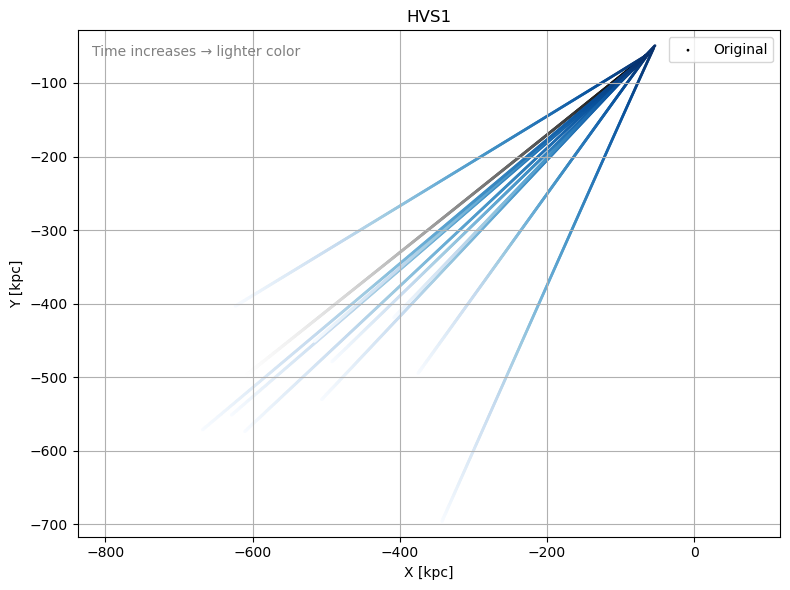

In [491]:
plt.figure(figsize=(8, 6))

n_steps = orbits[0].ntimes
times = np.linspace(0, 1, n_steps)

cmap_sampled = plt.colormaps['Blues']
cmap_original = plt.colormaps['Greys']

for i, orbit in enumerate(orbits):
    pos = orbit.pos.xyz.to(u.kpc).value
    if i == 0:
        colors = cmap_original(1 - times)
        plt.scatter(pos[0], pos[1], c=colors, s=1, label='Original')
    else:
        colors = cmap_sampled(1 - times)
        plt.scatter(pos[0], pos[1], c=colors, s=1, alpha=0.7)

plt.xlabel('X [kpc]')
plt.ylabel('Y [kpc]')
plt.title('HVS1')
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.text(0.02, 0.95, 'Time increases → lighter color',
         transform=plt.gca().transAxes,
         fontsize=10, color='gray')
plt.tight_layout()
plt.show()
